<a href="https://colab.research.google.com/github/Y4-Deep-Learning-Assignment/Pneumonia-_Detection/blob/EfficientNetB0/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNetB0 Transfer Learning for Pneumonia Detection

In [1]:
!nvidia-smi

Sat Oct 11 05:12:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install and import required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow keras numpy pandas matplotlib seaborn scikit-learn -q

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import os
import zipfile
from google.colab import files
import time
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [5]:
# Check GPU availability
print("\nGPU Available:", tf.test.is_gpu_available())
if tf.test.is_gpu_available():
    print("GPU Device:", tf.test.gpu_device_name())


GPU Available: True
GPU Device: /device:GPU:0


## Extract Dataset

In [6]:
import zipfile
import shutil

zip_path = "/content/drive/MyDrive/DL Assignment/archive.zip"

shutil.copy(zip_path, "/content/")

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset structure:")
!find /content/chest_xray -type d -print


Extracting dataset...
Dataset structure:
/content/chest_xray
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/__MACOSX/chest_xray/val
/content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/val/NORMAL
/content/chest_xray/__MACOSX/chest_xray/train
/content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX/chest_xray/test
/content/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/val/PNEUMONIA
/content/chest_xray/chest_xray/val/NORMAL
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/train/PNE

## Explore the Dataset

In [7]:
dataset_path = '/content/chest_xray'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
val_path = os.path.join(dataset_path, 'val')

def explore_dataset():
    print("Dataset Exploration:")
    print("=" * 50)

    for split in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split)
        normal_path = os.path.join(split_path, 'NORMAL')
        pneumonia_path = os.path.join(split_path, 'PNEUMONIA')

        normal_count = len(os.listdir(normal_path))
        pneumonia_count = len(os.listdir(pneumonia_path))
        total_count = normal_count + pneumonia_count

        print(f"\n{split.upper()} SET:")
        print(f"  Normal images: {normal_count}")
        print(f"  Pneumonia images: {pneumonia_count}")
        print(f"  Total images: {total_count}")
        print(f"  Pneumonia ratio: {pneumonia_count/total_count:.2%}")

explore_dataset()

📊 Dataset Exploration:

TRAIN SET:
  Normal images: 1341
  Pneumonia images: 3875
  Total images: 5216
  Pneumonia ratio: 74.29%

TEST SET:
  Normal images: 234
  Pneumonia images: 390
  Total images: 624
  Pneumonia ratio: 62.50%

VAL SET:
  Normal images: 8
  Pneumonia images: 8
  Total images: 16
  Pneumonia ratio: 50.00%


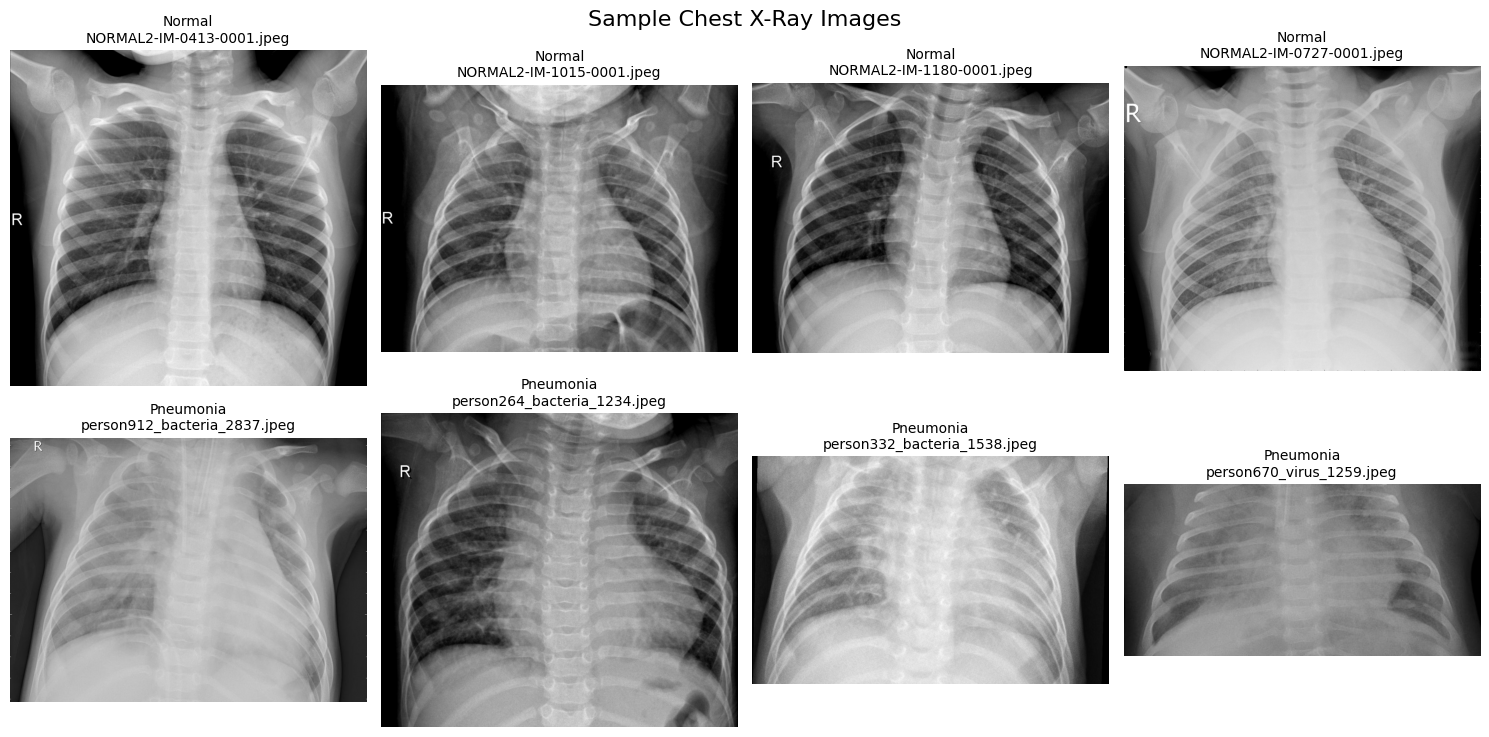

In [8]:
# Visualize sample images
def visualize_samples():
    """Display sample images from both classes"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Normal samples
    normal_path = os.path.join(train_path, 'NORMAL')
    normal_images = [f for f in os.listdir(normal_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:4]

    for i, img_name in enumerate(normal_images):
        img_path = os.path.join(normal_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Normal\n{img_name}', fontsize=10)
        axes[0, i].axis('off')

    # Pneumonia samples
    pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
    pneumonia_images = [f for f in os.listdir(pneumonia_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:4]

    for i, img_name in enumerate(pneumonia_images):
        img_path = os.path.join(pneumonia_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Pneumonia\n{img_name}', fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle('Sample Chest X-Ray Images', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

visualize_samples()

## Data Preprocessing and Augmentation

In [13]:
IMG_HEIGHT = 224  # EfficientNet works well with 224x224
IMG_WIDTH = 224
BATCH_SIZE = 32

print("Setting up data generators...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

Setting up data generators...


In [12]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Display class information
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print(f"\nData generators created successfully!")
print(f"Class indices: {class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class names: {class_names}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Data generators created successfully!
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624
Class names: ['NORMAL', 'PNEUMONIA']
